In [31]:
import sys, os
sys.path.append(os.path.abspath('../..'))
import os
import pandas as pd
from utlis.Ca_tools.roi_spike_vis_utlis import visualize_session, load_session_data # load_minian_data, calculate_dff

ms_folder = '/data/big_rim/rsync_dcc_sum/Oct3V1mini_sorted/20240916-V1-R1/customEntValHere/2024_10_14/16_38_19/My_V4_Miniscope'
df = load_session_data(ms_folder)
print(df.head())

      roi_0     roi_1     roi_2     roi_3     roi_4     roi_5     roi_6  \
0  3.262681  3.880505  1.766800  5.068011  1.337511  1.311171  0.564866   
1  4.864601  3.621568  1.881621  6.687844  2.846533 -0.066054  0.946437   
2  3.966872  3.669705  1.644186  3.809247  2.257686  1.803303  1.929760   
3  4.978353  3.429569  2.366802  3.592947  1.497141  1.180364  1.071725   
4  6.546924  3.578588  1.922534  2.047899  0.893617 -0.272738  1.716571   

      roi_7     roi_8     roi_9  ...    roi_74    roi_75    roi_76    roi_77  \
0 -1.283490  0.485513  1.160972  ...  1.816897  1.076673 -0.035509  0.300506   
1  2.767523  0.924967  0.454527  ...  1.996491  1.198753  0.053072 -0.653623   
2 -1.993157 -0.079758  0.087020  ...  1.419519  0.997301  0.493372 -0.436462   
3  8.159302  0.151915  1.345878  ...  1.559360  1.698648  0.160816 -0.255899   
4  2.897282 -0.508310  0.987038  ...  1.050830  0.405618  0.095141 -0.402782   

     roi_78  time_ms        qw        qx        qy        qz  
0  0.

Quaternion norms: min=1.0000, max=1.0000, mean=1.0000


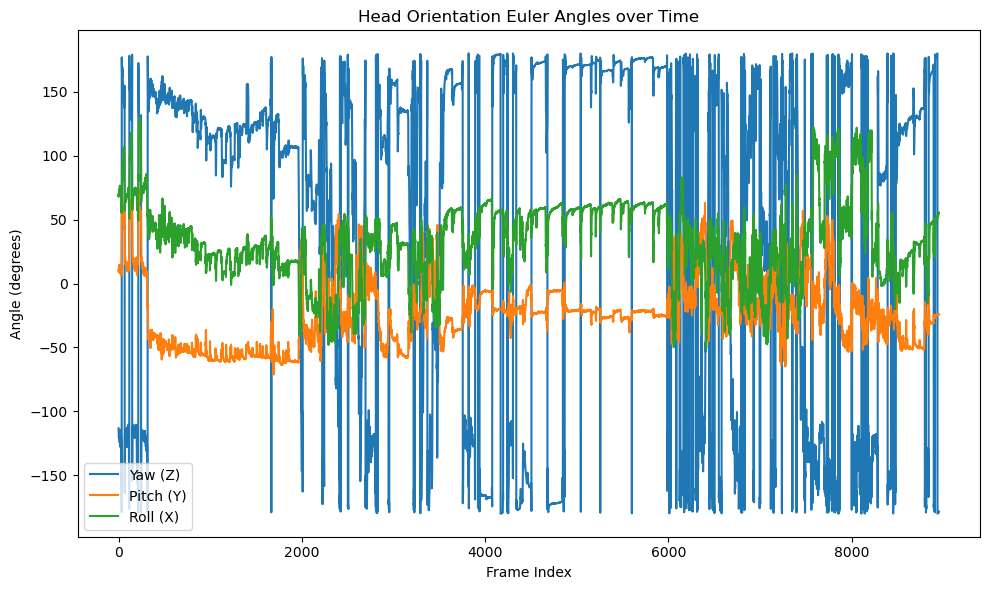

In [32]:

import numpy as np
import matplotlib.pyplot as plt

# —— 2. 检查范数 —— 
quats = df[['qx','qy','qz','qw']].to_numpy()
norms = np.linalg.norm(quats, axis=1)
print(f"Quaternion norms: min={norms.min():.4f}, max={norms.max():.4f}, mean={norms.mean():.4f}")

# —— 3. 如有必要，归一化 —— 
tol = 1e-3
if not np.allclose(norms, 1.0, atol=tol):
    quats = quats / norms[:, None]
    print("Detected norms ≠ 1.0 → 已归一化所有四元数")

# —— 4. 计算欧拉角 —— 
rot = R.from_quat(quats)                         # 期待 [x,y,z,w] 格式
angles = rot.as_euler('zyx', degrees=True)       # 返回 [yaw, pitch, roll]
yaw   = angles[:, 0]  # 绕 Z 轴
pitch = angles[:, 1]  # 绕 Y 轴
roll  = angles[:, 2]  # 绕 X 轴

# —— 5. 绘图 —— 
plt.figure(figsize=(10, 6))
plt.plot(yaw,   label='Yaw (Z)')
plt.plot(pitch, label='Pitch (Y)')
plt.plot(roll,  label='Roll (X)')
plt.xlabel('Frame Index')
plt.ylabel('Angle (degrees)')
plt.title('Head Orientation Euler Angles over Time')
plt.legend()
plt.tight_layout()
plt.show()

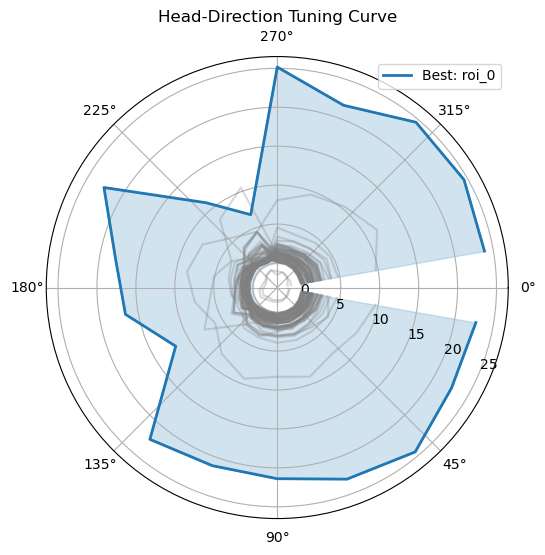

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R

def compute_headings_from_quat(quats, body_forward=(1,0,0)):
    """
    quats: (N,4) array of [qx, qy, qz, qw]
    body_forward: 机体坐标系下的“前向”参考向量，默认 X 轴正方向
    返回:
      headings: (N,) 水平面朝向角，0–360°（0° 对应 X 正方向，顺时针为角度增大方向）
    """
    # 1) 构建 Rotation 对象
    rot = R.from_quat(quats)  # SciPy expects [x,y,z,w]
    
    # 2) 把 body_forward 向量旋转到世界坐标
    fw = rot.apply(np.array(body_forward))  # shape (N,3)
    
    # 3) 计算 XY 平面上的朝向角
    raw = np.degrees(np.arctan2(fw[:,1], fw[:,0]))  # [-180,180]
    headings = (raw + 360) % 360
    return headings

def plot_hd_tuning(df, roi_cols, n_bins=18):
    """
    df: 包含 'qx','qy','qz','qw'，以及多列 roi_x 的 DataFrame
    roi_cols: list of ROI 列名，比如 ['roi_0','roi_1',...]
    n_bins: 调谐曲线的箱数
    """
    # 1) 得到 headings
    quats = df[['qx','qy','qz','qw']].to_numpy()
    headings = compute_headings_from_quat(quats)
    df['heading'] = headings
    
    # 2) 分箱
    bins = np.linspace(0, 360, n_bins+1)
    centers = (bins[:-1] + bins[1:]) / 2
    theta = np.deg2rad(centers)
    inds = np.digitize(headings, bins, right=False) - 1
    inds %= n_bins
    
    # 3) 计算每个 bin、每个 ROI 的平均响应
    tuning = np.zeros((len(roi_cols), n_bins))
    for i, roi in enumerate(roi_cols):
        for b in range(n_bins):
            vals = df.loc[inds==b, roi]
            tuning[i,b] = vals.mean() if len(vals)>0 else np.nan
    
    # 4) 画极坐标—每条曲线淡灰，最优 ROI 加粗高亮
    fig, ax = plt.subplots(subplot_kw={'projection':'polar'}, figsize=(6,6))
    # 计算向量长度选最优 ROI
    vec_len = np.abs((tuning * np.exp(1j * theta)).sum(axis=1))
    best = np.nanargmax(vec_len)
    
    for i in range(len(roi_cols)):
        ax.plot(theta, tuning[i], color='grey', alpha=0.3)
    ax.plot(theta, tuning[best], color='C0', linewidth=2,
            label=f'Best: {roi_cols[best]}')
    
    ax.fill_between(theta, tuning[best], alpha=0.2, color='C0')
    ax.set_xticks(np.deg2rad(np.arange(0,360,45)))
    ax.set_theta_zero_location('E')  # 0° 指向 X 轴正方向（右方）
    ax.set_theta_direction(-1)       # 顺时针为角度增大
    ax.set_title('Head‑Direction Tuning Curve')
    ax.legend(loc='upper right')
    plt.show()

# ——— 使用示例 ———

roi_columns = [c for c in df.columns if c.startswith('roi_')]
plot_hd_tuning(df, roi_columns, n_bins=18)


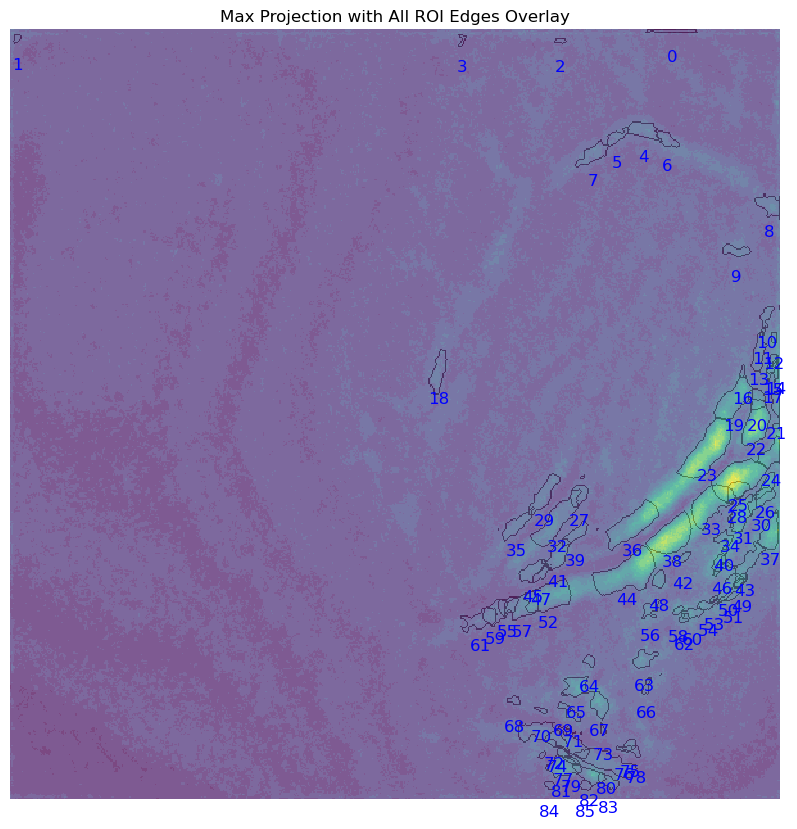

In [23]:
dff = visualize_session(ms_folder)

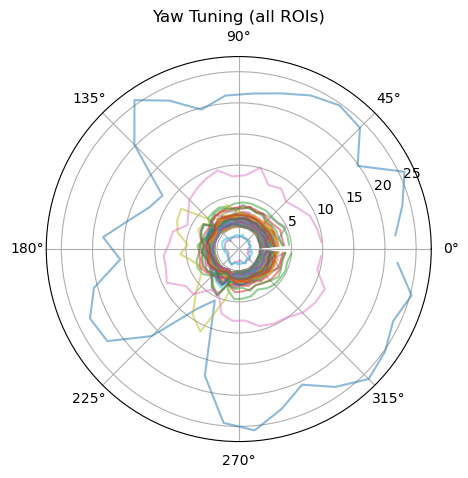

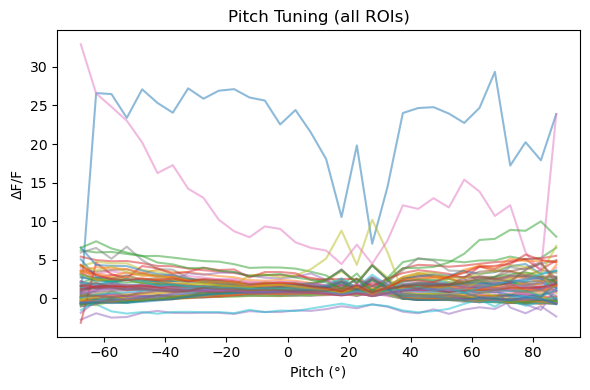

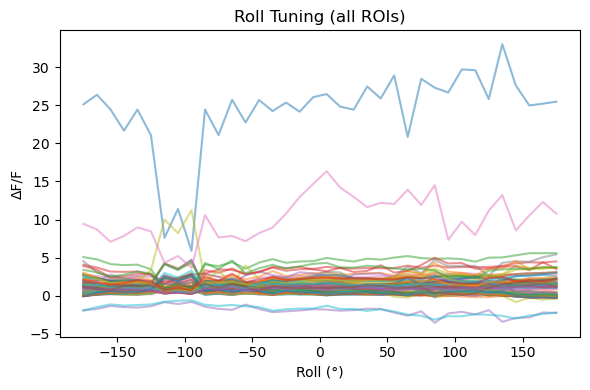

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R

def quat_to_physical_angles(quats):
    """
    quats: (N,4) array of [qx, qy, qz, qw]
    Returns three (N,) arrays: yaw(0–360), pitch(-90–90), roll(-180–180)
    """
    rot = R.from_quat(quats)
    # 前向向量和上向量
    fw = rot.apply(np.array([1,0,0]))   # shape (N,3)
    up = rot.apply(np.array([0,0,1]))   # shape (N,3)
    
    # Yaw: XY 平面上的方位
    raw_yaw = np.degrees(np.arctan2(fw[:,1], fw[:,0]))  # -180…180
    yaw = (raw_yaw + 360) % 360
    
    # Pitch: 抬头为正，低头为负
    horiz = np.linalg.norm(fw[:,:2], axis=1)
    pitch = np.degrees(np.arctan2(fw[:,2], horiz))     # -90…90
    
    # Roll: up 向量在机体前/右 平面上的倾斜
    hd = np.radians(yaw)
    # 机体前向（水平投影）和右向
    fx = np.stack([np.cos(hd), np.sin(hd), np.zeros_like(hd)], axis=1)
    fy = np.cross(fx, np.array([0,0,1.0]))
    ur = np.sum(up * fy, axis=1)
    uf = np.sum(up * fx, axis=1)
    roll = np.degrees(np.arctan2(ur, uf))               # -180…180
    
    return yaw, pitch, roll

def plot_all_roi_tuning(df, roi_cols, n_bins=36):
    # 1) 计算物理角度
    quats = df[['qx','qy','qz','qw']].to_numpy()
    yaw, pitch, roll = quat_to_physical_angles(quats)
    df['yaw'], df['pitch'], df['roll'] = yaw, pitch, roll

    # 2) 分别画三张图
    # —— 2.1 Yaw (Polar) —— 
    bins_y = np.linspace(0,360,n_bins+1)
    centers_y = (bins_y[:-1]+bins_y[1:])/2
    theta = np.deg2rad(centers_y)
    inds_y = np.digitize(yaw, bins_y, right=False)-1
    inds_y %= n_bins

    fig, ax = plt.subplots(subplot_kw={'projection':'polar'}, figsize=(6,5))
    for roi in roi_cols:
        tuning = [df.loc[inds_y==i, roi].mean() for i in range(n_bins)]
        ax.plot(theta, tuning, alpha=0.5)
    ax.set_title('Yaw Tuning (all ROIs)')
    ax.set_xticks(np.deg2rad(np.arange(0,360,45)))
    plt.show()

    # —— 2.2 Pitch (Linear) —— 
    bins_p = np.linspace(-90,90,n_bins+1)
    centers_p = (bins_p[:-1]+bins_p[1:])/2
    inds_p = np.digitize(pitch, bins_p)-1

    plt.figure(figsize=(6,4))
    for roi in roi_cols:
        tuning = [df.loc[inds_p==i, roi].mean() for i in range(n_bins)]
        plt.plot(centers_p, tuning, alpha=0.5)
    plt.title('Pitch Tuning (all ROIs)')
    plt.xlabel('Pitch (°)')
    plt.ylabel('ΔF/F')
    plt.tight_layout()
    plt.show()

    # —— 2.3 Roll (Linear) —— 
    bins_r = np.linspace(-180,180,n_bins+1)
    centers_r = (bins_r[:-1]+bins_r[1:])/2
    inds_r = np.digitize(roll, bins_r)-1

    plt.figure(figsize=(6,4))
    for roi in roi_cols:
        tuning = [df.loc[inds_r==i, roi].mean() for i in range(n_bins)]
        plt.plot(centers_r, tuning, alpha=0.5)
    plt.title('Roll Tuning (all ROIs)')
    plt.xlabel('Roll (°)')
    plt.ylabel('ΔF/F')
    plt.tight_layout()
    plt.show()

# ——— 使用示例 ———
# df = load_session_data(... )
roi_columns = [c for c in df.columns if c.startswith('roi_')]
plot_all_roi_tuning(df, roi_columns, n_bins=36)


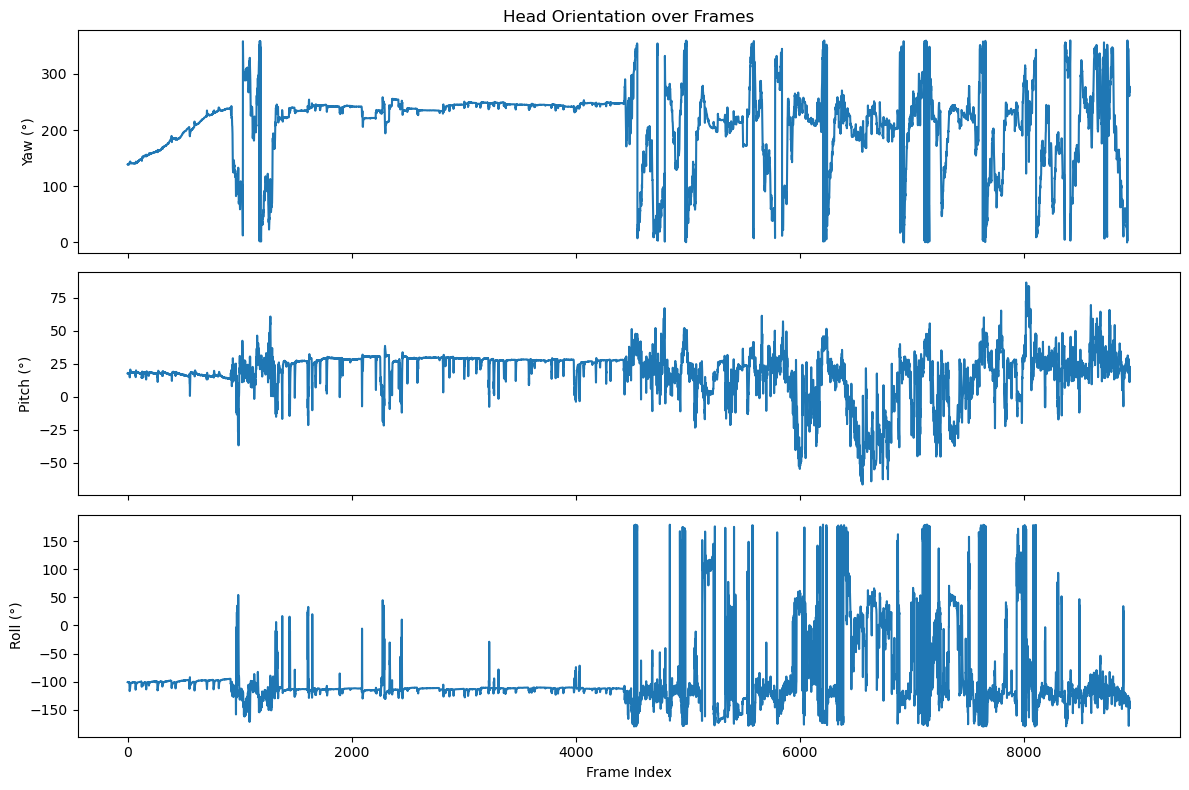

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R

def quat_to_physical_angles(quats):
    """
    quats: (N,4) array of [qx, qy, qz, qw]
    returns three (N,) arrays: yaw (0–360), pitch (–90–90), roll (–180–180)
    """
    rot = R.from_quat(quats)
    fw = rot.apply(np.array([1, 0, 0]))   # 前向向量
    up = rot.apply(np.array([0, 0, 1]))   # “上”向量

    # Yaw: XY 平面方位
    raw_yaw = np.degrees(np.arctan2(fw[:,1], fw[:,0]))
    yaw = (raw_yaw + 360) % 360

    # Pitch: 抬头正，低头负
    horiz = np.linalg.norm(fw[:,:2], axis=1)
    pitch = np.degrees(np.arctan2(fw[:,2], horiz))

    # Roll: 上向量在机体前/右平面上的倾斜
    hd = np.radians(yaw)
    fx = np.stack([np.cos(hd), np.sin(hd), np.zeros_like(hd)], axis=1)
    fy = np.cross(fx, np.array([0,0,1.0]))
    ur = np.sum(up * fy, axis=1)
    uf = np.sum(up * fx, axis=1)
    roll = np.degrees(np.arctan2(ur, uf))

    return yaw, pitch, roll

# — 假设 df 已包含 qx, qy, qz, qw 列 —
quats = df[['qx','qy','qz','qw']].to_numpy()
yaw, pitch, roll = quat_to_physical_angles(quats)

# —— 绘制时间序列 —— 
fig, axes = plt.subplots(3, 1, figsize=(12, 8), sharex=True)

axes[0].plot(yaw)
axes[0].set_ylabel('Yaw (°)')
axes[0].set_title('Head Orientation over Frames')

axes[1].plot(pitch)
axes[1].set_ylabel('Pitch (°)')

axes[2].plot(roll)
axes[2].set_ylabel('Roll (°)')
axes[2].set_xlabel('Frame Index')

plt.tight_layout()
plt.show()


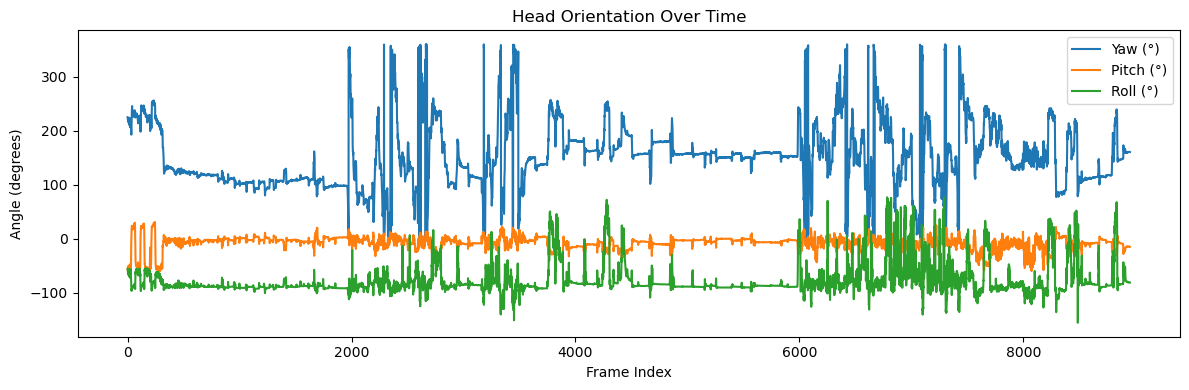

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R

def quat_to_physical_angles(quats):
    """
    quats: (N,4) array of [qx, qy, qz, qw]
    returns yaw (0–360), pitch (–90–90), roll (–180–180)
    """
    rot = R.from_quat(quats)
    fw = rot.apply(np.array([1,0,0]))
    up = rot.apply(np.array([0,0,1]))

    # Yaw
    raw_yaw = np.degrees(np.arctan2(fw[:,1], fw[:,0]))
    yaw = (raw_yaw + 360) % 360

    # Pitch
    horiz = np.linalg.norm(fw[:,:2], axis=1)
    pitch = np.degrees(np.arctan2(fw[:,2], horiz))

    # Roll
    hd = np.radians(yaw)
    fx = np.stack([np.cos(hd), np.sin(hd), np.zeros_like(hd)], axis=1)
    fy = np.cross(fx, np.array([0,0,1.0]))
    ur = np.sum(up * fy, axis=1)
    uf = np.sum(up * fx, axis=1)
    roll = np.degrees(np.arctan2(ur, uf))

    return yaw, pitch, roll

# —— 假设 df 已包含 qx, qy, qz, qw 列 —— 
quats = df[['qx','qy','qz','qw']].to_numpy()
yaw, pitch, roll = quat_to_physical_angles(quats)

# —— 绘制同一图 —— 
plt.figure(figsize=(12, 4))
plt.plot(yaw,   label='Yaw (°)')
plt.plot(pitch, label='Pitch (°)')
plt.plot(roll,  label='Roll (°)')
plt.xlabel('Frame Index')
plt.ylabel('Angle (degrees)')
plt.title('Head Orientation Over Time')
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()


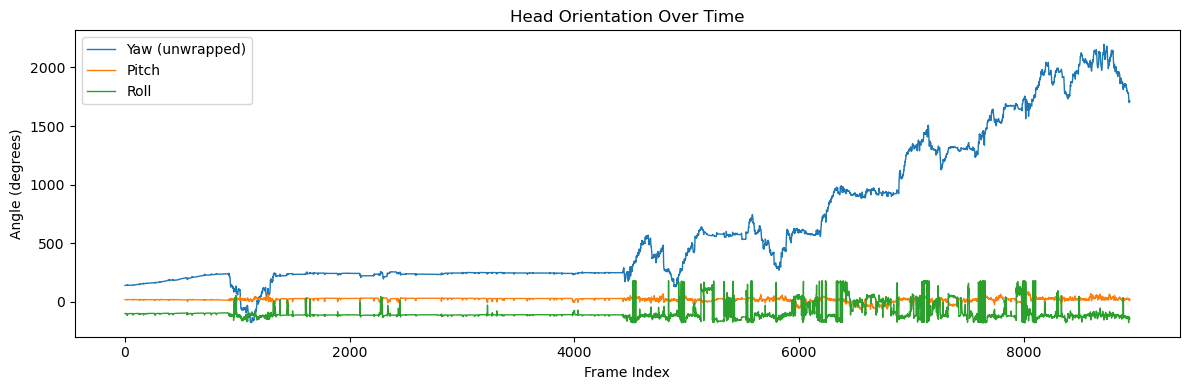

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R
import pandas as pd

# —————————————————————————————
# 1) 加载或准备你的 DataFrame df，
#    必须含有列 ['qx','qy','qz','qw']，
#    这里假设你已经有了 df：
#
# df = load_session_data(miniscope_folder)  
#    # 或者：
# # df = pd.read_csv('your_aligned_data.csv')
# —————————————————————————————

# 2) 提取四元数数组 [x,y,z,w]
quats = df[['qx','qy','qz','qw']].to_numpy()

def compute_physical_angles(quats):
    """
    输入 quats: (N,4) [qx,qy,qz,qw]
    输出：
      raw_yaw      – 原始 yaw in [-180,180]
      yaw_360      – mod 360 yaw in [0,360)
      yaw_unwrapped– 连续展开后的 yaw (deg)
      pitch        – pitch in [-90,90]
      roll         – roll in [-180,180]
    """
    # 构建 Rotation
    rot = R.from_quat(quats)

    # “前向”向量 & “上”向量 在世界坐标下
    fw = rot.apply(np.array([1, 0, 0]))  # shape (N,3)
    up = rot.apply(np.array([0, 0, 1]))  # shape (N,3)

    # —— Yaw —— 
    raw_yaw = np.degrees(np.arctan2(fw[:,1], fw[:,0]))         # [-180,180]
    yaw_360 = (raw_yaw + 360) % 360                            # [0,360)
    yaw_unwrapped = np.degrees(np.unwrap(np.radians(raw_yaw))) # 连续展开

    # —— Pitch —— 
    horiz = np.linalg.norm(fw[:,:2], axis=1)
    pitch = np.degrees(np.arctan2(fw[:,2], horiz))             # [-90,90]

    # —— Roll —— 
    hd_rad = np.radians(raw_yaw)
    fx = np.stack([np.cos(hd_rad), np.sin(hd_rad), np.zeros_like(hd_rad)], axis=1)
    fy = np.cross(fx, np.array([0,0,1.0]))
    ur = np.sum(up * fy, axis=1)
    uf = np.sum(up * fx, axis=1)
    roll = np.degrees(np.arctan2(ur, uf))                      # [-180,180]

    return raw_yaw, yaw_360, yaw_unwrapped, pitch, roll

# 3) 计算所有角度
raw_yaw, yaw_360, yaw_unwrapped, pitch, roll = compute_physical_angles(quats)

# 将它们存回 df（如有需要）
df['raw_yaw']      = raw_yaw
df['yaw_360']      = yaw_360
df['yaw_unwrapped']= yaw_unwrapped
df['pitch']        = pitch
df['roll']         = roll

# 4) 同一图上绘制：使用 yaw_unwrapped 而非 %360 后的值
plt.figure(figsize=(12, 4))
plt.plot(yaw_unwrapped, label='Yaw (unwrapped)', linewidth=1)
plt.plot(pitch,         label='Pitch',           linewidth=1)
plt.plot(roll,          label='Roll',            linewidth=1)
plt.xlabel('Frame Index')
plt.ylabel('Angle (degrees)')
plt.title('Head Orientation Over Time')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()


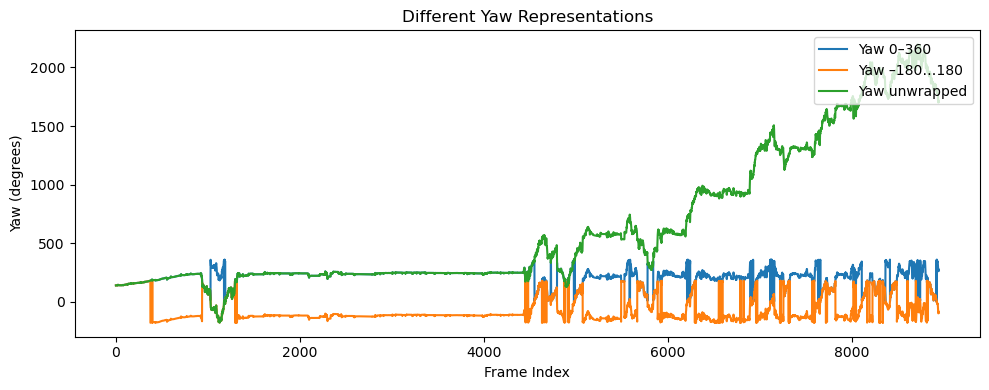

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R
import pandas as pd

# — 1) 加载你的 DataFrame df，保证它包含 ['qx','qy','qz','qw'] 四元数列 —
#    例如：
# df = load_session_data(miniscope_folder)
# 或者：
# df = pd.read_csv('aligned_data.csv')

# —— 2) 提取四元数数组 [x,y,z,w]
quats = df[['qx','qy','qz','qw']].to_numpy()

# —— 3) 计算三种 yaw 表示法 —— 
rot = R.from_quat(quats)
fw = rot.apply(np.array([1,0,0]))              # “前向”向量

# raw_yaw: [-180, +180]
raw_yaw = np.degrees(np.arctan2(fw[:,1], fw[:,0]))

# yaw_360: [0, 360)
yaw_360 = (raw_yaw + 360) % 360

# yaw_unwrapped: 连续展开，没有 360→0 跳跃
yaw_unwrapped = np.degrees(np.unwrap(np.radians(raw_yaw)))

# —— 4) 一起画到同一张图里 —— 
plt.figure(figsize=(10, 4))
plt.plot(yaw_360,      label='Yaw 0–360')
plt.plot(raw_yaw,      label='Yaw –180…180')
plt.plot(yaw_unwrapped, label='Yaw unwrapped')
plt.xlabel('Frame Index')
plt.ylabel('Yaw (degrees)')
plt.title('Different Yaw Representations')
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()
